In [47]:
import sys
from loguru import logger
from bs4 import BeautifulSoup
import pandas as pd
import regex as re
import networkx as nx
import matplotlib.pyplot as plt

logger.remove()
logger.add(sys.stderr, 
           level="INFO",
           format="{time:HH:mm:ss} | {level} | {message}")


csv_left = "Extracted Data/relationships_irgc.csv"
csv_right = "Extracted Data/relationships_mideast.csv"
csv_types = "Extracted Data/entity_types.csv"
xml_file = "MidEast_sanctions.xml"

In [48]:
def xml_to_json(element):

    """
    Recursively parses XML soup
    returning as JSON format 
    """
    
    if isinstance(element, str):
        return element
    
    if not element.contents:
        return element.string
    
    result = {}
    
    for child in element.children:
        
        if isinstance(child, str):
            continue
        
        if child.name not in result:
            result[child.name] = xml_to_json(child)
            
        else:
            if not isinstance(result[child.name], list):
                result[child.name] = [result[child.name]]
            result[child.name].append(xml_to_json(child))
            
    ## Capture text nodes without 'text' key
    if element.string and element.string.strip():
        return element.string.strip()
    
    return result



def extract_relationships(entity):
    
    """
    Given a JSON entity, return all available relationship information
    """
    
    name_ele = entity["names"]["name"]
    
    ### if name_ele is a dict, only one name entry exists
    if type(name_ele) == dict:
        
        #### Find Latin translation if more than one translation is present
        translation_element = name_ele["translations"]["translation"]
        
        if type(translation_element) == dict:
                entity_name = translation_element["formattedFullName"]

        elif type(translation_element) == list:
            for trans in translation_element:
                if trans["script"] == "Latin":
                    entity_name = trans["formattedFullName"]

    ### If name element is a list, aliases are present. Collect only primary name
    elif type(name_ele) == list:
        
        #### Find the primary name 
        for name in name_ele:
            if name["isPrimary"] == "true":
                translation_element = name["translations"]["translation"] 

                ##### Find Latin translation if more than one translation is present
                if type(translation_element) == dict:
                    entity_name = translation_element["formattedFullName"]
                                
                elif type(translation_element) == list:
                    for trans in translation_element:
                        if trans["script"] == "Latin":
                            entity_name = trans["formattedFullName"]



    ## Confirm entity includes relationship information, if not just return entity name and type
    if "relationships" not in entity.keys(): 
        return None
    if entity["relationships"] == None: 
        return None
    
    
    ## Collect relationship information
    relationships = entity["relationships"]["relationship"]
    rel_list = []
    
    ### if relationships is a dict, only one relationship is present
    if type(relationships) == dict:
        
        rel_type = relationships["type"]
        rel_entity = relationships["relatedEntity"]
        
        if rel_entity != None:
            rel_list = [entity_name, rel_type, rel_entity]
    
    ### If relationships is a list, multiple relationships are present 
    elif type(relationships) == list: 
        
        for rel in relationships:
            
            rel_type = rel["type"]
            rel_entity = rel["relatedEntity"]
            
            if rel_entity != None:
                rel_list.append([entity_name, rel_type, rel_entity]) 
            
    return rel_list




def format_name(entity_name):
    
    """
    Standardize the format for entity names retrieved from "formattedFullName"  
    """
    
    # Arrange name based on comma location, if present
    if ", " in entity_name:
        name_parts = entity_name.split(", ")
        entity_name = f"{name_parts[1]} {name_parts[0]}"
    
    # Apply title-case formatting
    entity_name = entity_name.title()
    
    # Capitalize any parenthetical text
    def capitalize(match):
        return match.group(1) + match.group(2).upper() + match.group(3)
    
    pattern = r'(\()([^\)]+)(\))'
    entity_name = re.sub(pattern, capitalize, entity_name)
    
    return entity_name




def create_graph(csv_input, csv_types):

        df_input = pd.read_csv(csv_input)
        df_types = pd.read_csv(csv_types)
        
        G = nx.Graph() 

        # Add nodes with entity_type property
        entities = set(df_input['entity_1']).union(set(df_input['entity_2']))
        
        for entity in entities:
            entity_type = df_types.loc[df_types['entity_name'] == entity, 'entity_type'].values
            
            if len(entity_type) > 0:
                G.add_node(entity, entity_type = entity_type[0])
            else:
                G.add_node(entity, entity_type = "Unknown")
                logger.error(f"Entity type not found | '{entity}' | {entity_type} |")
                
        # Add edges
        for _, row in df_input.iterrows():
            relationship_type = row['relationship']
            assert len(entity_type) > 0, f"Relationship type not found for entities: {row}"
            G.add_edge(row['entity_1'], row['entity_2'], relationship = relationship_type)
        
        return G
    
    
    
    
def join_graphs(G, H):

    """
    Add nodes and edges from H to G 
    where entities in H and not in G 
    have an edge with nodes in G
    """
    
    added_edges = 0
    joined_graph = G.copy()

    for u, v in H.edges():
        
        if G.has_node(u) or G.has_node(v):
            joined_graph.add_edge(u, v, **H[u][v])
            added_edges += 1
            logger.debug(f"Relationship added | Entity 1: {u} | Entity 2: {v} | Properties: {H[u][v]}")

    ## Debug information
    G_nodes = G.number_of_nodes()
    joined_nodes = joined_graph.number_of_nodes()
    added_nodes = joined_nodes - G_nodes
    
    logger.info(f"Join performed | G Nodes: {G.number_of_nodes()} | Nodes added: {added_nodes} | Edges added: {added_edges} | Joined graph nodes: {joined_graph.number_of_nodes()}")

    return joined_graph

In [49]:
def main(G, xml_file):
    
    """
    Accepts an XML of sanctions data, creates a network graph
    Joins graph H to input graph G, adding only nodes or edges from H
    where a node is shared between H and G.
    
    Returns a joined graph GH
    """
    
    ## Main Function
    ### Load XML Data
    try:
        with open(xml_file, "rb") as file:
            xml_data = file.read()
            logger.info(f"Loaded XML File")
            
    except FileNotFoundError:
        logger.error(f"Input file not found")
        
    except Exception as e:
        logger.error(f"An unexpected error occurred: {e}")
        
    
    ## Parse XML soup, isolate entity data
    soup = BeautifulSoup(xml_data, features='xml')
    entity_json = xml_to_json(soup)
    entity_data = entity_json['sanctionsData']["entities"]["entity"]
    entity_data = [entity for entity in entity_data if entity["generalInfo"]["entityType"] in ["Individual", "Entity"]]
    logger.info(f"Entities in input dataset: {len(entity_data)}")

    ## Extract Edges from JSON
    relationships = []
    
    for entity in entity_data:
        
        logger.debug(f"Extracting from entity: {entity["generalInfo"]["identityId"]}")
        rel_search = extract_relationships(entity)
      
        if rel_search:
            if type(rel_search[0]) == str:
                relationships.append(rel_search)
            
            elif type(rel_search == list):
                for rel in rel_search:
                    relationships.append(rel)
            
            
    ## Convert relationships into a dataframe, apply formatting  
    H_df = pd.DataFrame(relationships, columns = ['entity_1', 'relationship', 'entity_2'])       
    H_df["entity_1"] = H_df["entity_1"].apply(format_name)
    H_df["entity_2"] = H_df["entity_2"].apply(format_name)

    all_entities_set = set(H_df["entity_1"]).union(set(H_df["entity_2"]))
    logger.info(f"Entities found with relationship data: {len(all_entities_set)}")
    logger.info(f"Number of relationships found: {H_df.shape[0]}")
    
    ## Create H graph from input data
    df_types = pd.read_csv(csv_types)
    
    H = nx.Graph() 
    
    ### Add nodes
    entities = set(H_df['entity_1']).union(set(H_df['entity_2']))
    
    for entity in entities:
        entity_type = df_types.loc[df_types['entity_name'] == entity, 'entity_type'].values
        
        if len(entity_type) > 0:
            H.add_node(entity, entity_type = entity_type[0])
        else:
            H.add_node(entity, entity_type = "Unknown")
            logger.error(f"Entity type not found | '{entity}' | {entity_type} |")
            
    ### Add edges
    for _, row in H_df.iterrows():
        relationship_type = row['relationship']
        assert len(relationship_type) > 0, f"Relationship type not found for entities: {row}"
        H.add_edge(row['entity_1'], row['entity_2'], relationship = relationship_type)
        

    ## Join G and H
    added_edges = 0
    joined_graph = G.copy()
    
    for u, v in H.edges():
        
        if G.has_node(u) or G.has_node(v):
            joined_graph.add_edge(u, v, **H[u][v])
            added_edges += 1
            logger.debug(f"Relationship added | Entity 1: {u} | Entity 2: {v} | Properties: {H[u][v]}")

    ## Debug information
    added_nodes = joined_graph.number_of_nodes() - G.number_of_nodes()
    added_edges = joined_graph.number_of_edges() - G.number_of_edges()
    
    logger.info(f"Join Complete")
    logger.info(f" G   | Nodes: {G.number_of_nodes()} | Edges: {G.number_of_edges()}")
    logger.info(f" H   | Nodes: {H.number_of_nodes()} | Edges: {H.number_of_edges()}")
    logger.info(f" GH  | Nodes: {joined_graph.number_of_nodes()} | Edges {joined_graph.number_of_edges()}")
    logger.info(f" Dif | Nodes: {added_nodes} | Edges: {added_edges}")
                
    return joined_graph

G = create_graph(csv_left, csv_types)
joined_graph = main(G, xml_file)

22:20:21 | INFO | Loaded XML File
22:20:27 | INFO | Entities in input dataset: 1520
22:20:27 | INFO | Entities found with relationship data: 654
22:20:27 | INFO | Number of relationships found: 604
22:20:28 | ERROR | Entity type not found | 'Special Units Of Iran’S Law Enforcement Forces' | [] |
22:20:28 | ERROR | Entity type not found | 'Iran’S Counter-Terror Special Forces' | [] |
22:20:28 | INFO | Join Complete
22:20:28 | INFO |  G   | Nodes: 169 | Edges: 167
22:20:28 | INFO |  H   | Nodes: 654 | Edges: 603
22:20:28 | INFO |  GH  | Nodes: 224 | Edges 222
22:20:28 | INFO |  Dif | Nodes: 55 | Edges: 55


## Proof of Concept

In [64]:
def visualize_graph(G):                                                                    
    
    plt.figure(figsize = (12, 8))
    pos = nx.kamada_kawai_layout(G)

    # Draw nodes with specific colors
    node_colors = [G.nodes[node].get('color', 'skyblue') for node in G.nodes()]
    edge_colors = [G.edges[edge].get('color', 'black') for edge in G.edges()]

    nx.draw_networkx_nodes(G, pos, node_size = 50, node_color = node_colors)
    nx.draw_networkx_edges(G, pos, edge_color = edge_colors)
    nx.draw_networkx_labels(G, pos, font_size = 5, font_color = 'black')


    ## Draw Graph
    plt.title('Network Graph')
    plt.show()
    
    
def highlight_unique_elements(G, H):
    
    # Highlight unique nodes
    for node in G.nodes():
        if node not in H:
            G.nodes[node]['color'] = 'red'
    
    # Highlight unique edges
    for u, v in G.edges():
        if not H.has_edge(u, v):
            G.edges[u, v]['color'] = 'red'
    
    return G

def largest_subgraph(G):
    
    # sorted = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
    S = [G.subgraph(c).copy() for c in nx.connected_components(G)]

    return S[0]


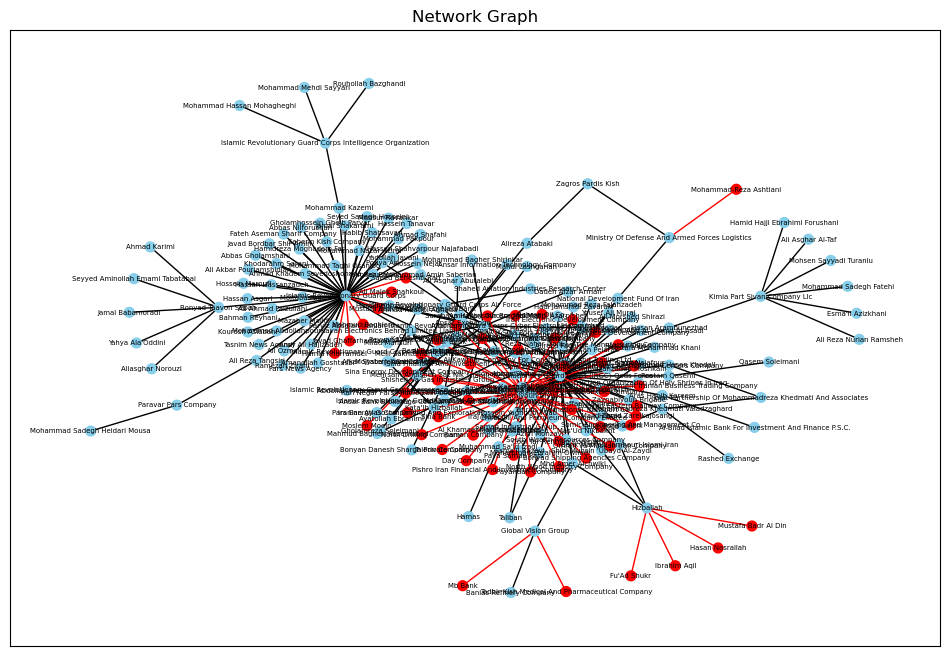

In [66]:
joined_highlighted = highlight_unique_elements(joined_graph, G)
visualize_graph(joined_highlighted)

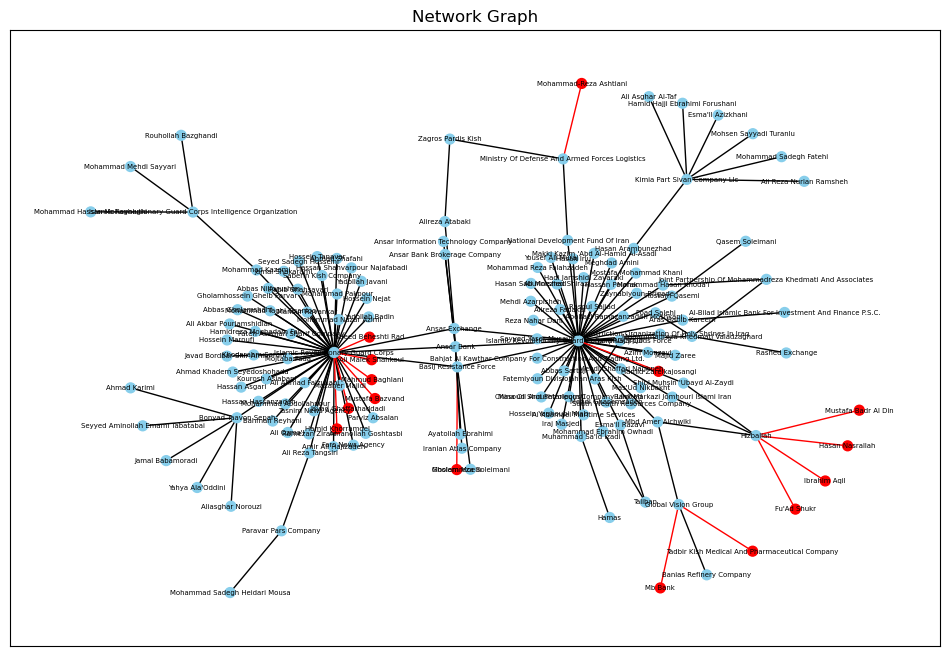

In [65]:
visualize_graph(largest_subgraph(joined_graph))